In [1]:
%matplotlib inline

this extension makes it easy to reload the imports without restarting the whole notebook

In [2]:
%load_ext autoreload

run this cell if you want to reload the imports (i.e. you changed notebookfns.py)

In [3]:
%autoreload

In [4]:
# these are all standard Python modules
import glob
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle

In [5]:
# this is my notebookfns.py file
import notebookfns as n

In [6]:
font = {'family' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
plt.rc('lines', linewidth=3)
plt.rc('axes', linewidth=3)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)

note that these errors include the weights alpha_1, alpha_2, alpha_3
red is training error, blue is validation error


/Users/blusch/Documents/DeepKoopmanResults/notebookfns.py:10: RuntimeWarning: divide by zero encountered in log10
  errors[:, j] = np.log10(errors[:, j])
/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


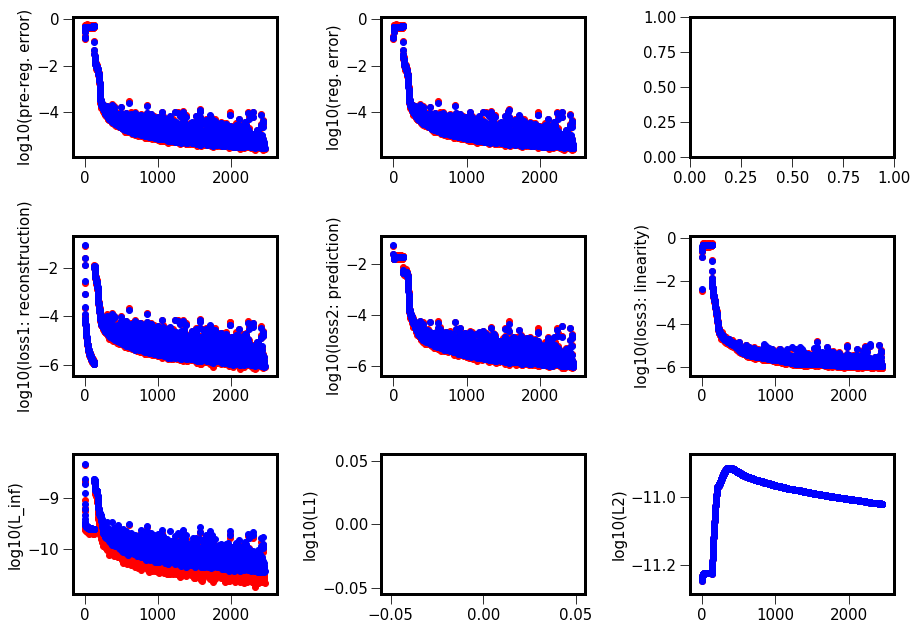

In [7]:
# You can change this filename to point to the pickle file for your model.
# Later code loads the related files (i.e. weights & biases) by changing the end of the filename
fname = './CylinderBox/CylinderBox5_2018_03_09_21_25_31_280190_model.pkl'
errors = np.loadtxt(fname.replace('model.pkl','error.csv'),delimiter=',')
n.PlotErrors(errors, range(0,16))

In [8]:
# you may need the encoding part if you save the pickle file in Python 2 and load it in Python 3 
with open(fname, 'rb') as f:
    params = pickle.load(f, encoding='latin1')

In [9]:
print('validation error: %.4E' % params['minTest'])

validation error: 2.9339E-06


In [10]:
print('We had %d files of training data.' % params['data_train_len'])
print('Length of trajectories: %d steps (goes in Table 2)' % params['len_time'])
print('Batch size: %d (goes in Table 2)' % params['batch_size'])
deltat = params['delta_t']
print('delta_t (time stepping in data): %.3f' % deltat)
T = deltat*(params['len_time']-1)
tSpan = np.linspace(start=0,stop=T,num=params['len_time'],endpoint=True)
print("Time span is %r" % tSpan)

We had 4 files of training data.
Length of trajectories: 101 steps (goes in Table 2)
Batch size: 128 (goes in Table 2)
delta_t (time stepping in data): 0.010
Time span is array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])


In [11]:
print("For Table 4:")
print('log10 of alpha_1 (the weight on losses involving reconstruction): %.1f' % np.log10(params['recon_lam']))
print('log10 of alpha_2 (the weight on L_inf term): %.1f' % np.log10(params['Linf_lam']))
print('log10 of alpha_3 (the weight on L_2 regularization): %.1f' % np.log10(params['L2_lam']))

For Table 4:
log10 of alpha_1 (the weight on losses involving reconstruction): -1.0
log10 of alpha_2 (the weight on L_inf term): -9.0
log10 of alpha_3 (the weight on L_2 regularization): -13.0


In [12]:
print('The training was allowed to run up to %.1f hours' % (params['max_time']/(60*60)))
print('The training actually ran for %.1f hours' % (params['time_exp']/(60*60)))
print('The stop condition was: %s' % params['stop_condition'])

The training was allowed to run up to 6.0 hours
The training actually ran for 6.0 hours
The stop condition was: past max time


In [13]:
print('Did we do the autoencoder pre-training? %d' % params['auto_first'])
print('The learning rate was %.2E' % params['learning_rate'])

Did we do the autoencoder pre-training? 1
The learning rate was 1.00E-03


In [14]:
print('We penalized %d (S_p) steps for prediction. (goes in Table 4)' % params['num_shifts'])
print('We penalized %d steps in the linearity loss.' %params['num_shifts_middle'])

We penalized 30 (S_p) steps for prediction. (goes in Table 4)
We penalized 100 steps in the linearity loss.


In [15]:
# load all of the weights and biases into W and b dictionaries
W, b = n.load_weights_koopman(fname, len(params['widths'])-1, len(params['widths_omega_real'])-1, params['num_real'], params['num_complex_pairs'])

In [16]:
# load the validation data
params['data_name'] = 'FluidFlowBox' # temp fix
X = np.loadtxt('%s_val_x.csv' % params['data_name'],delimiter=',')

In [17]:
# reshape the validation data
max_shifts_to_stack = n.num_shifts_in_stack(params)
X_stacked, num_traj_val = n.stack_data(X, max_shifts_to_stack, params['len_time'])
print("We used %d trajectories in the validation set." % num_traj_val)

# Xk is just the initial conditions of each trajectory
Xk = np.squeeze(X_stacked[0,:,:])

We used 5000 trajectories in the validation set.


In [18]:
# apply the network to just the initial conditions Xk
# output the data transformed to y-coordinates (steps k, k+1, k+2, k+3 are steps 0, 1, 2, 3 here)
# also output the reconstructed Xk and the predictions for three steps
yk, ykplus1, ykplus2, ykplus3, xk_recon, xkplus1, xkplus2, xkplus3 = n.ApplyKoopmanNetOmegas(Xk, W, b, params['delta_t'], params['num_real'], params['num_complex_pairs'], params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])

In [19]:
# apply the network to just the initial conditions Xk
# output the data transformed to y-coordinates (steps k, k+1, k+2, k+3 are steps 0, 1, 2, 3 here)
# also output the reconstructed Xk and the predictions for three steps
y, g_list = n.ApplyKoopmanNetOmegasFull(X_stacked, W, b, params['delta_t'], params['num_shifts'], params['num_shifts_middle'], params['num_real'], params['num_complex_pairs'], params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])

In [20]:
# calculate the validation loss, split over the loss components
loss1_val, loss2_val, loss3_val, loss_Linf_val, loss_val = n.define_loss(X_stacked, y, g_list, params, W, b)

In [21]:
print('Reconstruction loss (on validation set): %.4E' % loss1_val)
print('Prediction loss (on validation set): %.4E' % loss2_val)
print('Linearity loss (on validation set): %.4E' % loss3_val)
print('L_inf loss (on validation set): %.4E' % loss_Linf_val)
print('Pre-regularization loss (on validation set): %.4E (goes in Table 1)' % loss_val)

Reconstruction loss (on validation set): 9.0479E-07
Prediction loss (on validation set): 9.5746E-07
Linearity loss (on validation set): 1.0716E-06
L_inf loss (on validation set): 3.5530E-11
Pre-regularization loss (on validation set): 2.9339E-06 (goes in Table 1)


In [22]:
loss_L1_val, loss_L2_val, regularized_loss_val = n.define_regularization(params, W, b, loss_val)
print('L1 penalty (on weights): %.4E' % loss_L1_val)
print('L2 penalty (on weights): %.4E' % loss_L2_val)
print('Total regularized loss (on validation set): %.4E' % regularized_loss_val)

L1 penalty (on weights): 0.0000E+00
L2 penalty (on weights): 9.5737E-12
Total regularized loss (on validation set): 2.9339E-06


In [23]:
print('Sanity check:')
print('Compare to validation loss recorded during training: %.4E' % params['minTest'])
print('Compare to regularized validation loss recorded during training: %.4E' %params['minRegTest'])

Sanity check:
Compare to validation loss recorded during training: 2.9339E-06
Compare to regularized validation loss recorded during training: 2.9339E-06


In [24]:
# apply the auxiliary network to the encoded data
omegas = n.omega_net_apply(yk, W, b, params['num_real'], params['num_complex_pairs'], params['num_omega_weights'])

In [25]:
# The auxiliary network outputs the parameters for the eigenvalues in the K matrix.
# For each pair of complex conjugate eigenvalues, the continuous time version would be lambda = mu +/- i omega
# The discrete time version is exp(lambda delta t) 
# By Euler's formula, can also write this as exp(mu deltat) * (cos(omega deltat) + i sin(omega deltat))
# The auxiliary network outputs mu and omega
#
# For each real eigenvalue, the continuous time version is mu
# The discrete time version is exp(mu delta t)
# Again, the aux. network outputs mu

print('Omega1 ranges from %.3f to %.3f (so there is almost no change in the frequency)' % (np.min(omegas[0][:,0]), np.max(omegas[0][:,0])))
print('Mu1 ranges from %.6f to %.6f (so the growth/decay varies)' % (np.min(omegas[0][:,1]), np.max(omegas[0][:,1])))
print('Mu2 ranges from %.6f to %.6f (so the growth/decay varies a little)' % (np.min(omegas[1]), np.max(omegas[1])))
print('Recall: delta_t = %.2f' % deltat) 

Omega1 ranges from 0.994 to 1.002 (so there is almost no change in the frequency)
Mu1 ranges from -0.156596 to 0.096500 (so the growth/decay varies)
Mu2 ranges from -10.342652 to -9.776643 (so the growth/decay varies a little)
Recall: delta_t = 0.01


In [26]:
print('To set axis ticks on next few figures:')
print('The first y coordinate ranges from %.3f to %.3f.' % (np.min(yk[:,0]), np.max(yk[:,0])))
print('The second y coordinate ranges from %.3f to %.3f.' % (np.min(yk[:,1]), np.max(yk[:,1])))

To set axis ticks on next few figures:
The first y coordinate ranges from -0.746 to 0.760.
The second y coordinate ranges from -0.741 to 0.732.


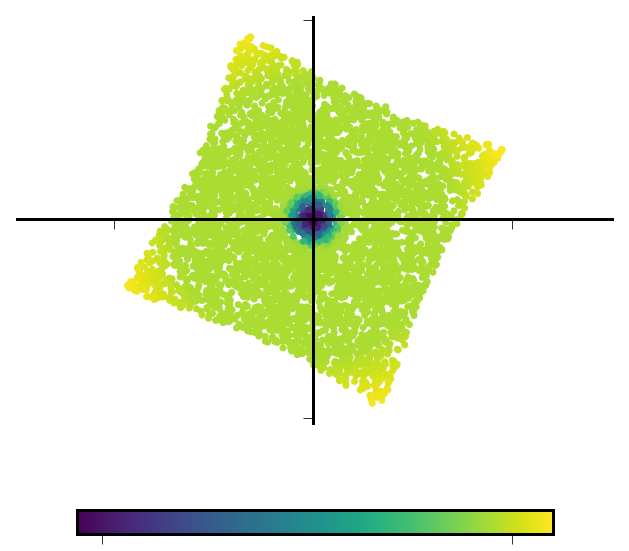

In [27]:
# Similar to Supplementary Figure 9
fig = plt.figure(figsize=(16/3*2,16/3*2))
ax = fig.add_subplot(111)
sc = ax.scatter(np.asarray(yk[:,0]), np.asarray(yk[:,1]), c=np.asarray(omegas[0][:,0]))
CBI = plt.colorbar(sc, orientation='horizontal', shrink=.8, ticks = [.994, 1.001])
CBI.ax.set_xticklabels(['',''])

xlab = [-.8,0,.8]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-.8, 0, .8]
plt.yticks(ylab, xlabels)
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.axis('equal')

plt.savefig('CylinderOffBowlEvals1.svg', dpi=200, transparent=True)
plt.show()

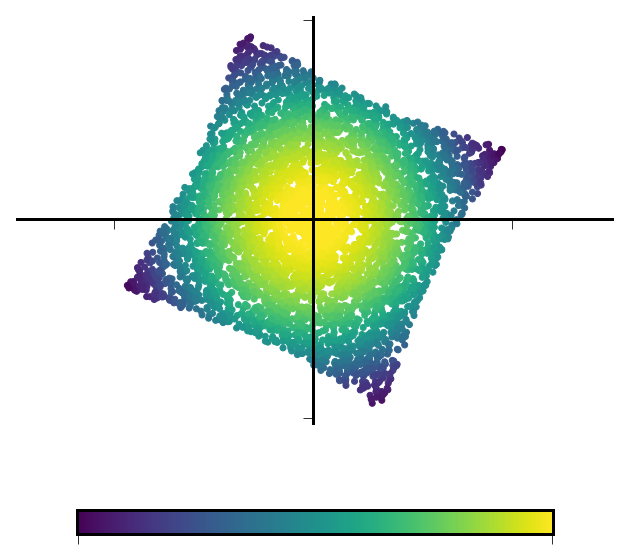

In [28]:
# Similar to Supplementary Figure 9
fig = plt.figure(figsize=(16/3*2,16/3*2))
ax = fig.add_subplot(111)
sc = ax.scatter(np.asarray(yk[:,0]), np.asarray(yk[:,1]), c=np.asarray(omegas[0][:,1]))
CBI = plt.colorbar(sc, orientation='horizontal', shrink=.8, ticks = [-.156, .096])
CBI.ax.set_xticklabels(['',''])

xlab = [-.8,0,.8]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-.8, 0, .8]
plt.yticks(ylab, xlabels)
#plt.ylim([-.4, .55])
#plt.xlim([-.4, .4])
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.axis('equal')

plt.savefig('CylinderOffBowlEvals2.svg', dpi=200, transparent=True)
plt.show()

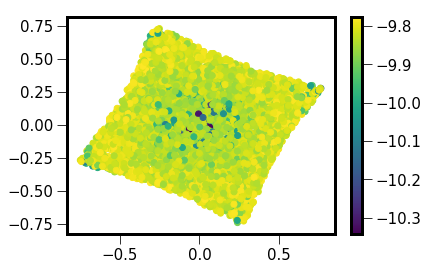

In [29]:
fig = plt.figure()
cax = plt.scatter(np.asarray(yk[:,0]), np.asarray(yk[:,1]), c=np.asarray(omegas[1]))
fig.colorbar(cax)

In [30]:
print('Reconstruction error on initial conditions: %.2E' % np.mean(np.square(Xk - xk_recon)))
print('1-step prediction error on initial conditions: %.2E' % np.mean(np.square(xkplus1 - np.squeeze(X_stacked[1,:,:]))))
print('2-step prediction error on initial conditions: %.2E' % np.mean(np.square(xkplus2 - np.squeeze(X_stacked[2,:,:]))))

Reconstruction error on initial conditions: 9.05E-06
1-step prediction error on initial conditions: 7.91E-06
2-step prediction error on initial conditions: 7.64E-06


In [31]:
print('Relative reconstruction error on initial conditions: %.2E' % (np.mean(np.square(Xk - xk_recon))/np.mean(np.square(Xk))))
print('Relative 1-step prediction error on initial conditions: %.2E' % (np.mean(np.square(xkplus1 - np.squeeze(X_stacked[1,:,:])))/np.mean(np.square(np.squeeze(X_stacked[1,:,:])))))
print('Relative 2-step prediction error on initial conditions: %.2E' % (np.mean(np.square(xkplus2 - np.squeeze(X_stacked[2,:,:])))/np.mean(np.square(np.squeeze(X_stacked[2,:,:])))))

Relative reconstruction error on initial conditions: 9.86E-06
Relative 1-step prediction error on initial conditions: 9.20E-06
Relative 2-step prediction error on initial conditions: 9.41E-06


In [32]:
data = Xk.copy()

In [33]:
# For other plots, it's helpful to consider a full grid of input data
# Create a mesh grid and reshape it
xvals = np.linspace(np.min(data[:,0]),np.max(data[:,0]),300)
yvals = np.linspace(np.min(data[:,1]),np.max(data[:,1]),300)
X, Y = np.meshgrid(xvals, yvals)

grid = np.zeros((90000,3))
grid[:,0] = np.reshape(X, (90000,))
grid[:,1] = np.reshape(Y, (90000,))
print(grid.shape)

(90000, 3)


In [34]:
# Apply the network to the whole grid
grid_yk, grid_ykplus1, grid_ykplus2, grid_ykplus3, grid_xk_recon, grid_xkplus1, grid_xkplus2, grid_xkplus3 = n.ApplyKoopmanNetOmegas(grid, W, b, params['delta_t'], params['num_real'], params['num_complex_pairs'], params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])

In [35]:
grid_reshaped0 = grid_yk[:,0].reshape(300,300)
grid_reshaped1 = grid_yk[:,1].reshape(300,300)
grid_reshaped2 = grid_yk[:,2].reshape(300,300)

In [36]:
# Nice to draw a black outline
outline_x1 = np.asarray([-1.1, -1.1, 1.1])
outline_y1 = np.asarray([-1.1, 1.1, 1.1])
outline_x2 = np.asarray([-1.1, 1.1, 1.1])
outline_y2 = np.asarray([-1.1, -1.1, 1.1])

In [37]:
print('To set levels and color bar ticks on next few figures:')
print('The first y coordinate ranges from %.3f to %.3f.' % (np.min(grid_reshaped0), np.max(grid_reshaped0)))
print('The second y coordinate ranges from %.3f to %.3f.' % (np.min(grid_reshaped1), np.max(grid_reshaped1)))
print('The third y coordinate ranges from %.3f to %.3f.' % (np.min(grid_reshaped2), np.max(grid_reshaped2)))

To set levels and color bar ticks on next few figures:
The first y coordinate ranges from -0.768 to 0.775.
The second y coordinate ranges from -0.772 to 0.762.
The third y coordinate ranges from -0.003 to 0.470.


[-6.00000000e-01 -4.00000000e-01 -2.00000000e-01  1.11022302e-16
  2.00000000e-01  4.00000000e-01  6.00000000e-01]


<Figure size 432x288 with 0 Axes>

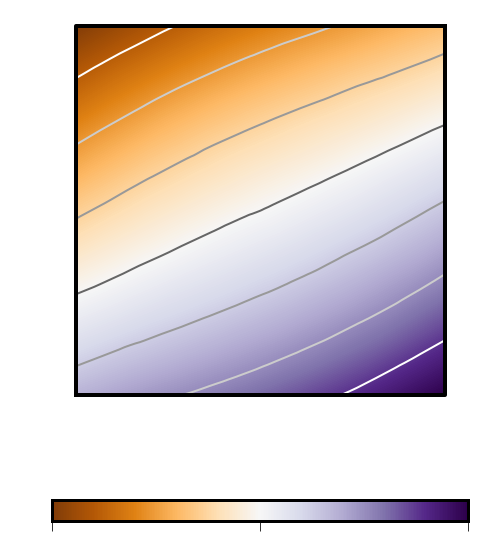

In [38]:
# Similar to Supplementary Figure 8
# Plot first eigenfunction (on first two dimensions)
n.EigenfunctionPlot('PuOr',grid_reshaped0, outline_x1, outline_y1, outline_x2, outline_y2, X, Y, filename='CylinderOffBowlEigenfunction1.png', levels=np.arange(-.6,.8,.2), cbTicks=[-.78,0,.78], climits=[-.78,.78])

[-6.00000000e-01 -4.00000000e-01 -2.00000000e-01  1.11022302e-16
  2.00000000e-01  4.00000000e-01  6.00000000e-01]


<Figure size 432x288 with 0 Axes>

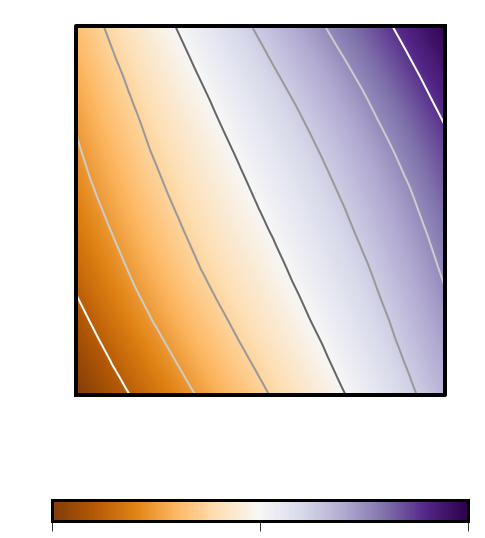

In [39]:
# Similar to Supplementary Figure 8
# Plot second eigenfunction (on first two dimensions)
n.EigenfunctionPlot('PuOr',grid_reshaped1, outline_x1, outline_y1, outline_x2, outline_y2, X, Y, filename='CylinderOffBowlEigenfunction2.png', levels=np.arange(-.6,.8,.2), cbTicks=[-.78,0,.78], climits=[-.78,.78])

Eigenfunction ranges in magnitude from 0.000001 to 0.679699
[0 1 2]


/usr/local/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


<Figure size 432x288 with 0 Axes>

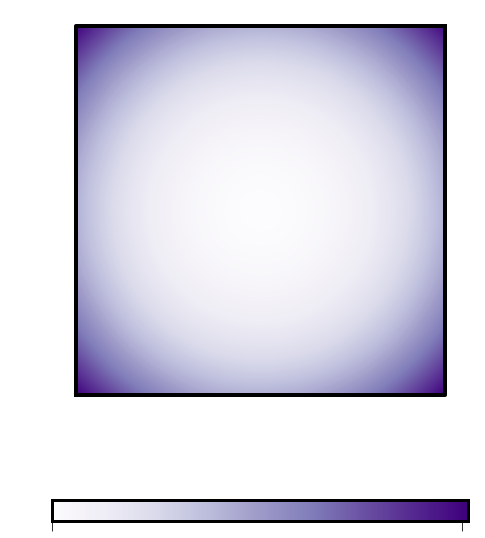

In [40]:
# Similar to Supplementary Figure 8
# calculate the magnitude (coloring in this figure)
efn_magnitude = np.square(grid_reshaped0) + np.square(grid_reshaped1)
print('Eigenfunction ranges in magnitude from %.6f to %.6f' % (np.nanmin(efn_magnitude), np.nanmax(efn_magnitude)))

# purposely not showing levels
n.EigenfunctionPlot('Purples', efn_magnitude, outline_x1, outline_y1, outline_x2, outline_y2, X, Y, filename='CylinderOffBowlMagnitudeEigenfunction.png', cbFlag=True, levels=np.arange(0,3,1), cbTicks=[0,.67])

Ranges in phase from -3.141528 to 3.141592
[-4, 4]


<Figure size 432x288 with 0 Axes>

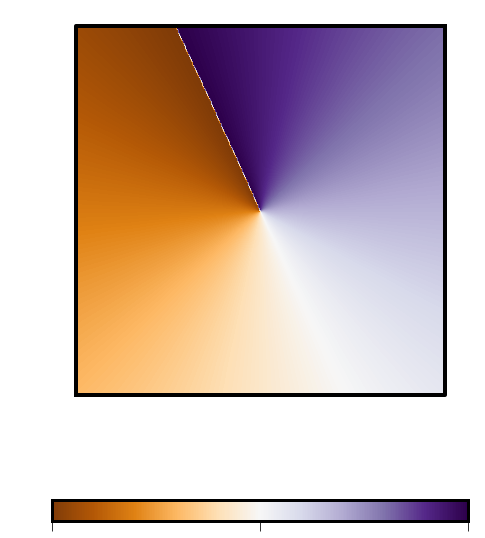

In [41]:
# Similiar to Supplementary Figure 8
# calculate the phase (coloring in this figure)
efn_phase = np.arctan2(grid_reshaped1,grid_reshaped0)
print('Ranges in phase from %.6f to %.6f' % (np.nanmin(efn_phase), np.nanmax(efn_phase)))

# purposely not showing levels
n.EigenfunctionPlot('PuOr',efn_phase, outline_x1, outline_y1, outline_x2, outline_y2, X, Y, filename='CylinderOffBowlPhaseEigenfunction.png', cbFlag=True, levels=[-4,4], cbTicks=[-3.14,0,3.14])

In [42]:
# for plotting, load an example trajectory and apply the network
temp = np.loadtxt("FluidFlowBox_traj1_x.csv",delimiter=',')

lenTtraj = temp.shape[0]
traj = temp[np.arange(lenTtraj-1),:]
trajkplus1 = temp[np.arange(lenTtraj-1)+1,:]

tSpantraj = np.linspace(0,100,lenTtraj)

traj_yk, traj_ykplus1, traj_ykplus2, traj_ykplus3, traj_xk_recon, traj_xkplus1, traj_xkplus2, traj_xkplus3 = n.ApplyKoopmanNetOmegas(traj, W, b, params['delta_t'], params['num_real'], params['num_complex_pairs'], params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])


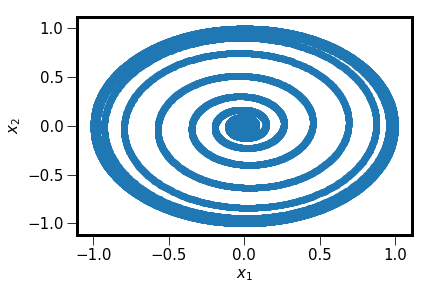

In [43]:
# plot the first two dimensions of this trajectory
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.asarray(traj[:,0]), np.asarray(traj[:,1]))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()

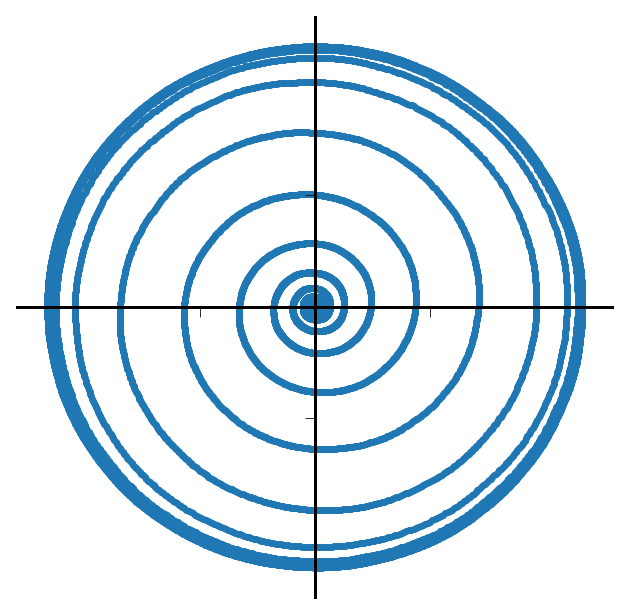

In [44]:
# Supplementary Figure 7b
# plot this one trajectory, but in y-coordinates (first two)
fig = plt.figure(figsize=(16/3*2,16/3*2))
ax = fig.add_subplot(111)

ax.scatter(np.asarray(traj_yk[:,0]), np.asarray(traj_yk[:,1]))

xlab = [-.2,0,.2]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-.2,0,.2]
ylabels = ''
plt.yticks(ylab,ylabels)
#plt.axis('off')
#plt.axis('equal')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

plt.savefig('OffBowlLinear.svg', dpi=200, transparent=True)

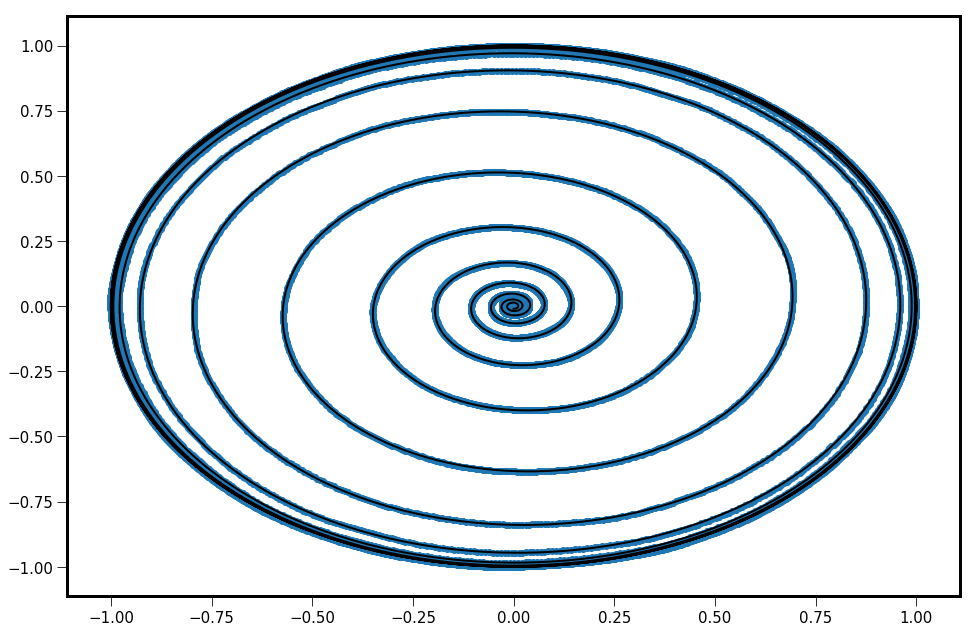

In [45]:
# plot reconstruction error on this trajectory (first two coordinates)
fig = plt.figure(figsize=(16,16/3*2))
ax = fig.add_subplot(111)


plt.plot(np.array(traj[:,0]), np.array(traj[:,1]), 'k', linewidth=2)
plt.scatter(np.array(traj_xk_recon[:,0]),np.array(traj_xk_recon[:,1]))

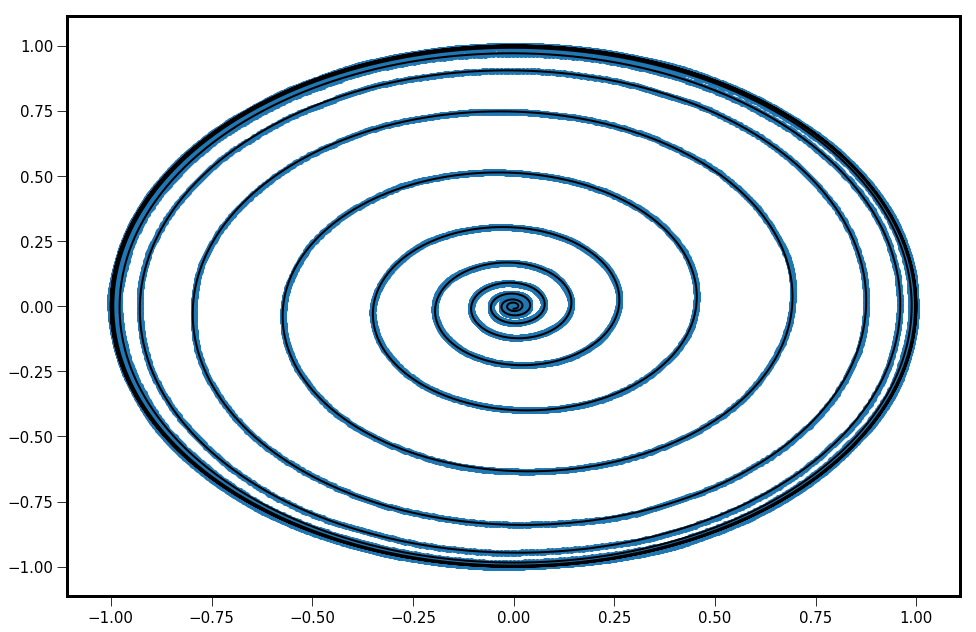

In [46]:
# plot 1-step prediction error on this one trajectory (first two coordinates)
fig = plt.figure(figsize=(16,16/3*2))
ax = fig.add_subplot(111)

plt.plot(np.array(trajkplus1[:,0]), np.array(trajkplus1[:,1]), 'k', linewidth=2)
plt.scatter(np.array(traj_xkplus1[:,0]),np.array(traj_xkplus1[:,1]))

In [50]:
%matplotlib notebook

In [51]:
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


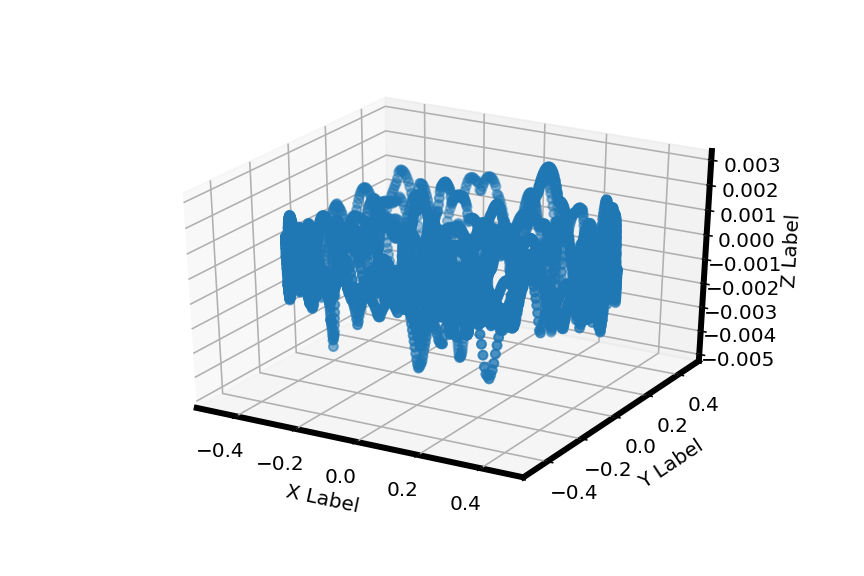

In [52]:
# plot this one trajectory, but in y-coordinates (all three)
# Note: this trajectory is on the "bowl" (attractor) already, so we expect the third coordinate to vary little
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.array(traj_yk[:,0]), np.array(traj_yk[:,1]), np.array(traj_yk[:,2]))
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


<IPython.core.display.Javascript object>


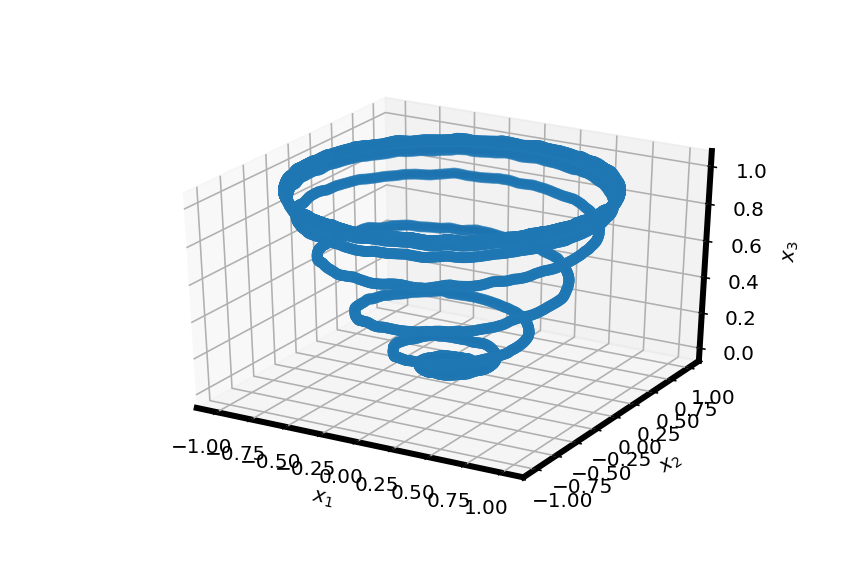

In [53]:
# plot reconstruction error on this trajectory (all three coordinates)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(np.array(traj[:,0]), np.array(traj[:,1]), np.array(traj[:,2]), 'k')
ax.scatter(np.array(traj_xk_recon[:,0]), np.array(traj_xk_recon[:,1]), np.array(traj_xk_recon[:,2]))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')

plt.show()


<IPython.core.display.Javascript object>


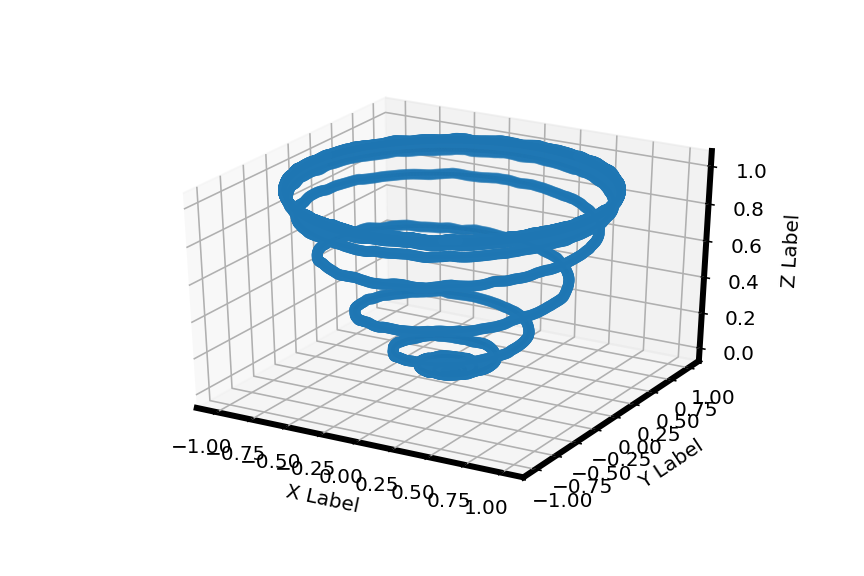

In [54]:
# plot 1-step prediction error on this one trajectory (all three coordinates)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(np.array(trajkplus1[:,0]), np.array(trajkplus1[:,1]), np.array(trajkplus1[:,2]), 'k', linewidth=2)
ax.scatter(np.array(traj_xkplus1[:,0]),np.array(traj_xkplus1[:,1]),np.array(traj_xkplus1[:,2]))
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [55]:
%matplotlib inline

In [56]:
# now apply network to this trajectory again, but this time for many steps
# this time, only network initial condition of the trajectory.
traj_long_pred = np.zeros(traj.shape)

num_steps = traj_long_pred.shape[0]-1
omega_ic = np.zeros((1,1))

ic = np.squeeze(traj[0,:])
traj_long_pred[0,:] = ic
# (num_examples, num_steps, n)
traj_long_pred[1:,:] = n.PredictKoopmanNetOmegas(ic, W, b, deltat, num_steps, params['num_real'], params['num_complex_pairs'], 
                                                        params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])

    

trajectory: worst rel. error 1.053
	first ind with error > 10p: 1 of 10000


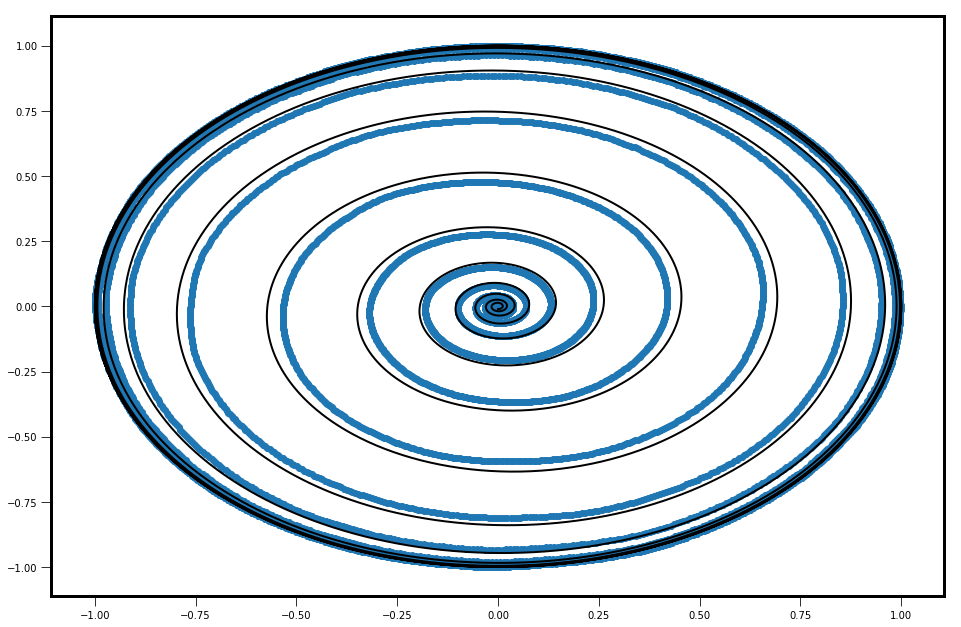

In [57]:
# plot long-term prediction:
# if only give network initial condition, then have network predict many steps, how long is it accurate?
fig = plt.figure(figsize=(16,16/3*2))
ax = fig.add_subplot(111)

plt.plot(traj[:,0],traj[:,1], 'k', linewidth=2)
diffs = np.linalg.norm(traj - traj_long_pred,ord=2,axis=1)
normalize = np.linalg.norm(traj,ord=2,axis=1)
relerr = diffs/normalize
print("trajectory: worst rel. error %.3f" % (np.max(relerr)))
indBigErr = np.nonzero(relerr > .1) # 10% error 
if len(indBigErr[0]) > 0:
    print("\tfirst ind with error > 10p: %d of %d"  % (indBigErr[0][0], traj.shape[0]) )

plt.scatter(traj_long_pred[:,0],traj_long_pred[:,1])


In [58]:
%matplotlib notebook

<IPython.core.display.Javascript object>


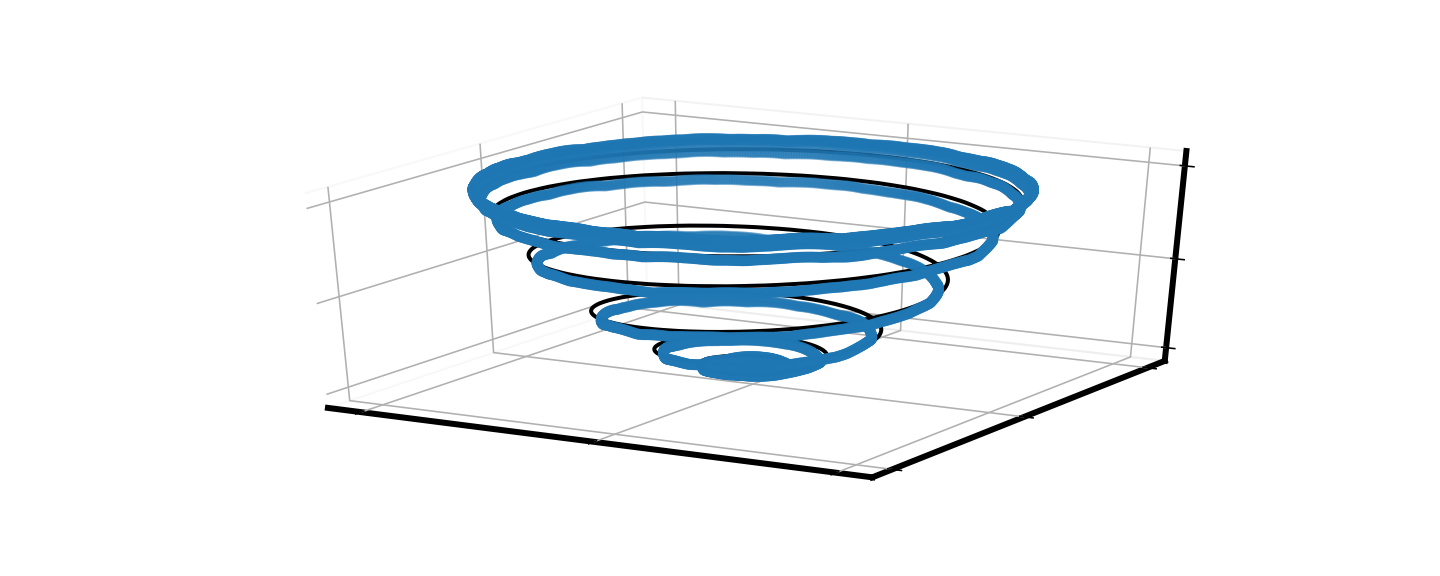

In [59]:
# plot long-term prediction again, but 3d this time
fig = plt.figure()
fig.set_figwidth(10)
ax = fig.add_subplot(111, projection='3d')

ax.plot(np.array(traj[:,0]), np.array(traj[:,1]), np.array(traj[:,2]), 'k', linewidth=2)
ax.scatter(np.array(traj_long_pred[:,0]),np.array(traj_long_pred[:,1]),np.array(traj_long_pred[:,2]))

xlab = [-1,0,1]
xlabels = ''
ax.set_xticks(xlab)
ax.set_xticklabels(xlabels)

ylab = [-1,0,1]
ylabels = ''
ax.set_yticks(ylab)
ax.set_yticklabels(ylabels)

zlab = [0,0.5,1]
zlabels = ''
ax.set_zticks(zlab)
ax.set_zticklabels(zlabels)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

plt.show()
fig.savefig('OffBowlLongPred.svg', dpi=200, transparent=True)


<IPython.core.display.Javascript object>


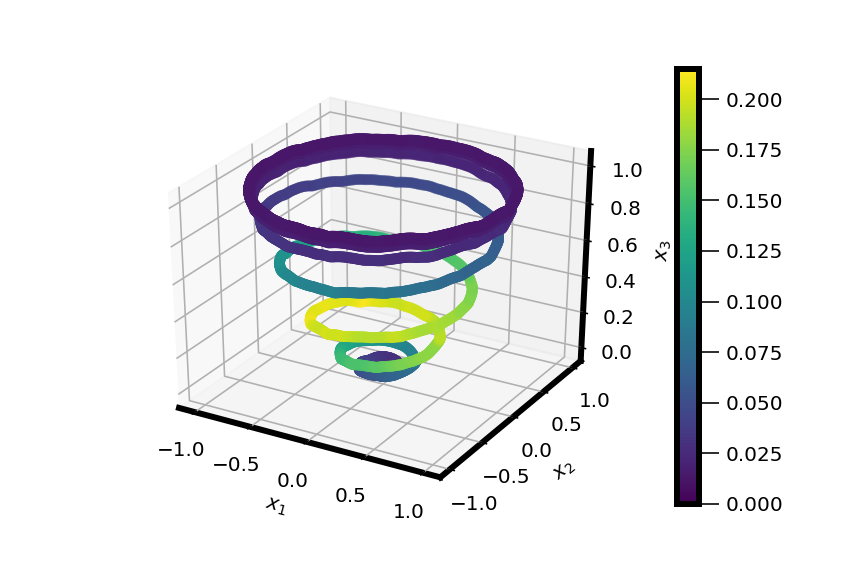

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

diffs = np.sum(np.square(traj - traj_long_pred), axis=1)
cax = ax.scatter(np.array(traj_long_pred[:,0]),np.array(traj_long_pred[:,1]),np.array(traj_long_pred[:,2]), c=diffs)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
fig.colorbar(cax)

plt.show()


In [61]:
# for plotting, load another example trajectory and apply the network
# this time, it starts outside the "bowl" (attractor)
temp = np.loadtxt("FluidFlowBox_traj2_x.csv",delimiter=',')

lenTtraj = temp.shape[0]
traj2 = temp[np.arange(lenTtraj-1),:]
traj2kplus1 = temp[np.arange(lenTtraj-1)+1,:]

tSpantraj = np.linspace(0,100,lenTtraj)

traj2_yk, traj2_ykplus1, traj2_ykplus2, traj2_ykplus3, traj2_xk_recon, traj2_xkplus1, traj2_xkplus2, traj2_xkplus3 = n.ApplyKoopmanNetOmegas(traj2, W, b, params['delta_t'], params['num_real'], params['num_complex_pairs'], params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])


In [62]:
%matplotlib inline

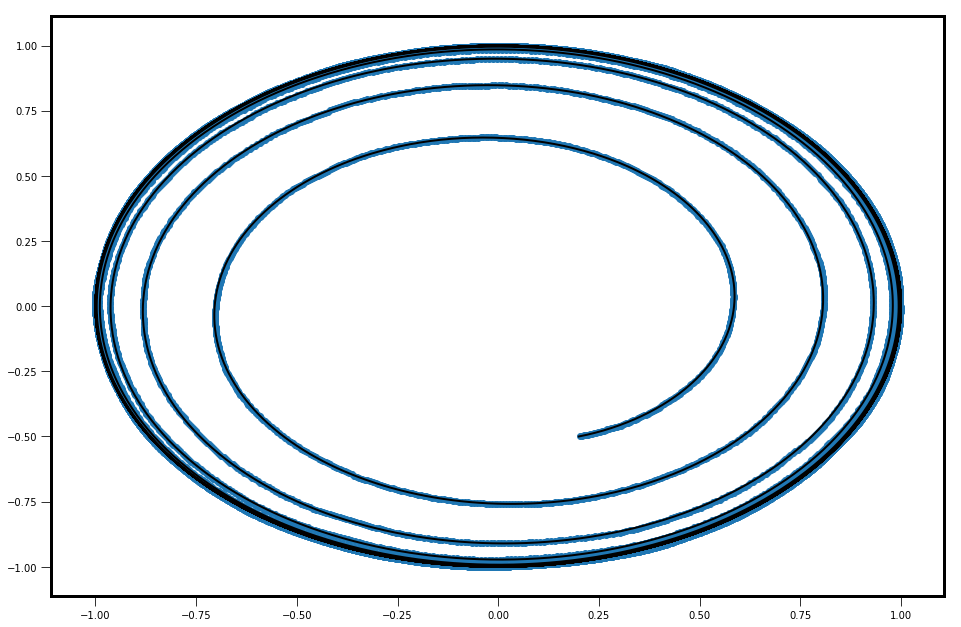

In [63]:
# plot reconstruction error on this trajectory (first two coordinates)
fig = plt.figure(figsize=(16,16/3*2))
ax = fig.add_subplot(111)


plt.plot(np.array(traj2[:,0]), np.array(traj2[:,1]), 'k', linewidth=2)
plt.scatter(np.array(traj2_xk_recon[:,0]),np.array(traj2_xk_recon[:,1]))

In [64]:
# now apply network to this trajectory again, but this time for many steps
# this time, only network initial condition of the trajectory.
traj2_long_pred = np.zeros(traj2.shape)

num_steps = traj2_long_pred.shape[0]-1
omega_ic = np.zeros((1,1))

ic = np.squeeze(traj2[0,:])
traj2_long_pred[0,:] = ic
traj2_long_pred[1:,:] = n.PredictKoopmanNetOmegas(ic, W, b, deltat, num_steps, params['num_real'], params['num_complex_pairs'], 
                                                        params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])

    

trajectory: worst rel. error 0.052


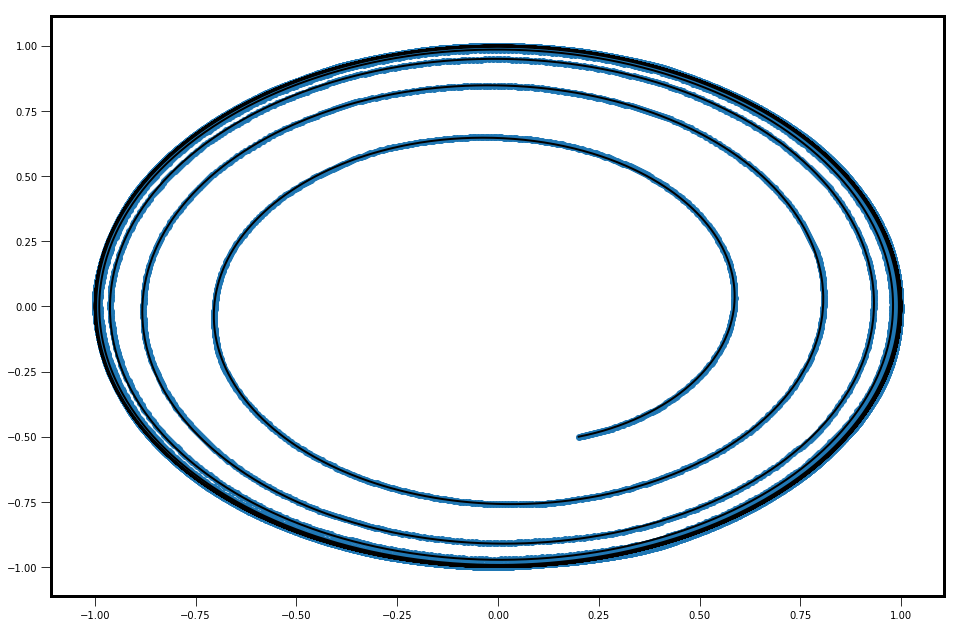

In [65]:
# plot long-term prediction:
# if only give network initial condition, then have network predict many steps, how long is it accurate?
fig = plt.figure(figsize=(16,16/3*2))
ax = fig.add_subplot(111)

plt.plot(traj2[:,0],traj2[:,1], 'k', linewidth=2)
diffs = np.linalg.norm(traj2 - traj2_long_pred,ord=2,axis=1)
normalize = np.linalg.norm(traj2,ord=2,axis=1)
relerr = diffs/normalize
print("trajectory: worst rel. error %.3f" % (np.max(relerr)))
indBigErr = np.nonzero(relerr > .1) # 10% error 
if len(indBigErr[0]) > 0:
    print("\tfirst ind with error > 10p: %d of %d"  % (indBigErr[0][0], traj2.shape[0]) )

plt.scatter(traj2_long_pred[:,0],traj2_long_pred[:,1])


In [66]:
%matplotlib notebook

<IPython.core.display.Javascript object>


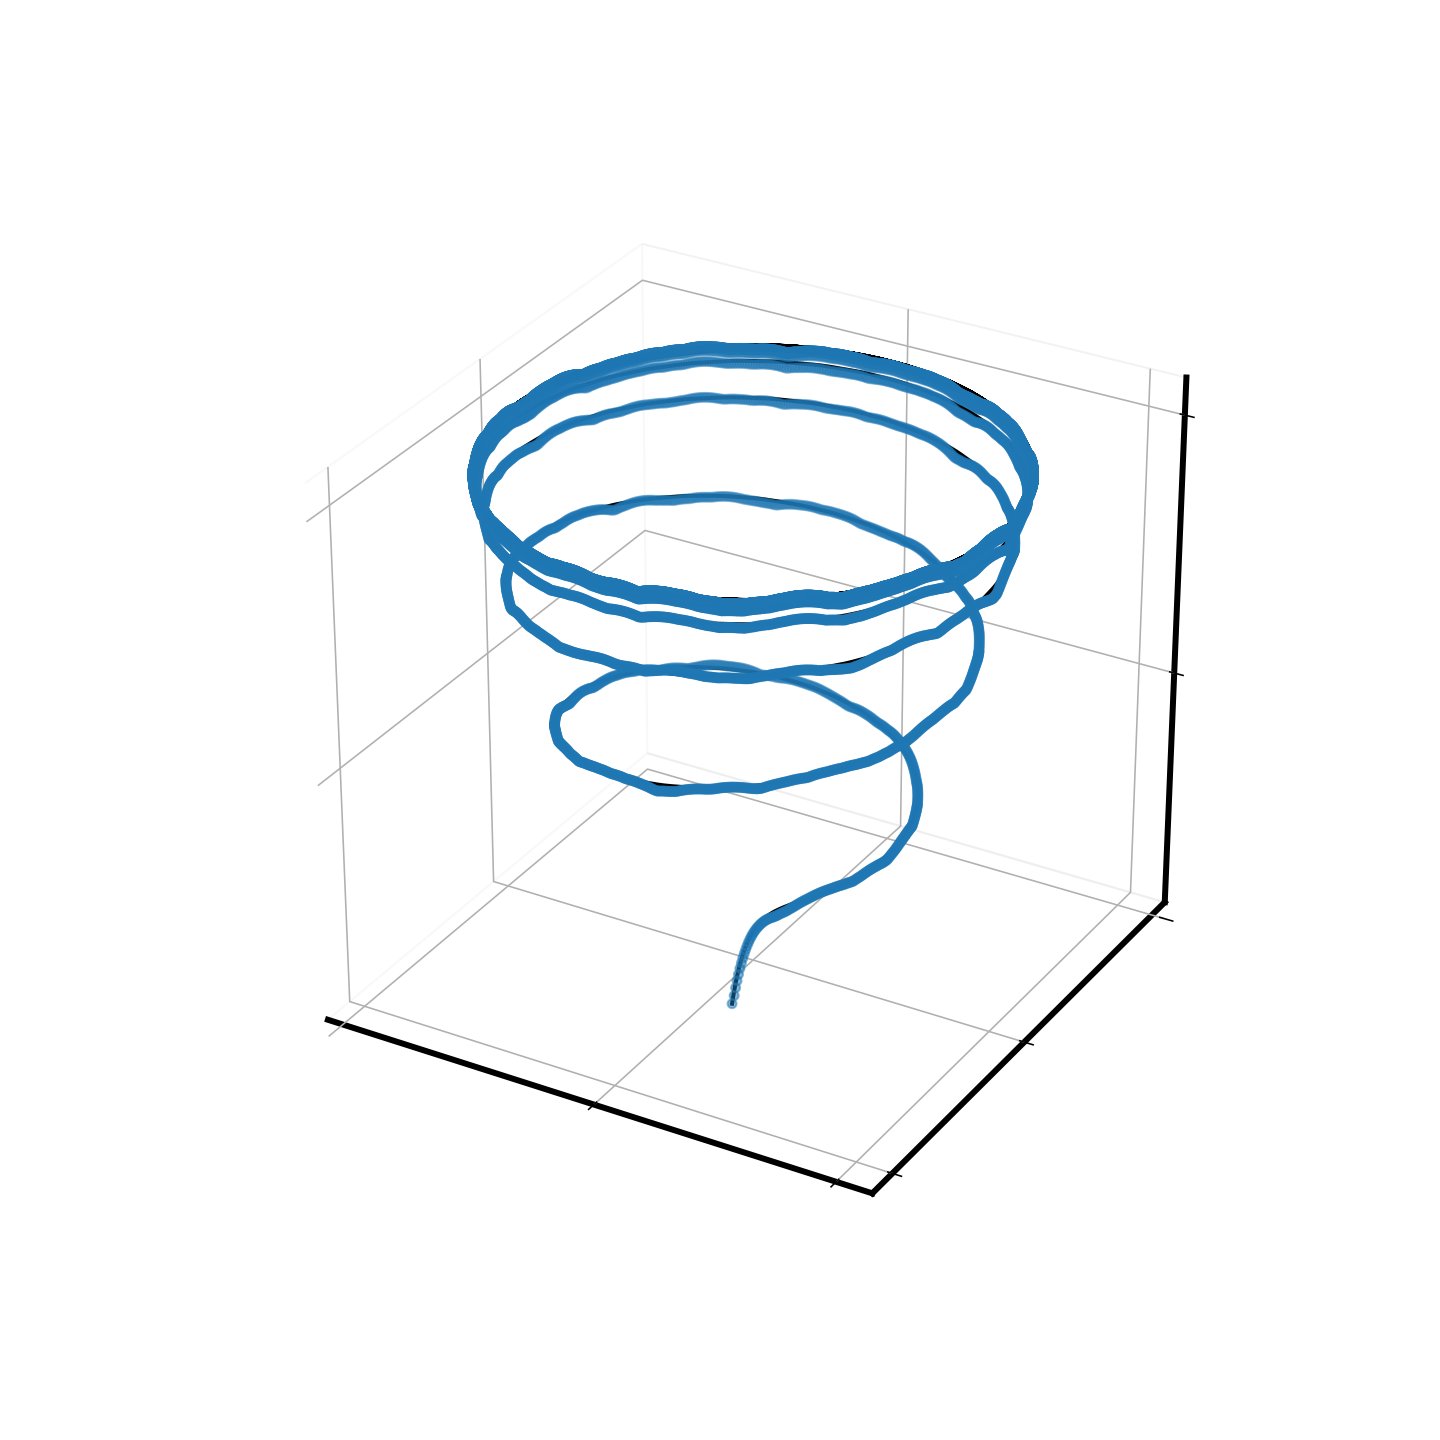

In [67]:
# Figure 6c, left
# plot long-term prediction again, but 3d this time
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax = fig.add_subplot(111, projection='3d')

ax.plot(np.array(traj2[:,0]), np.array(traj2[:,1]), np.array(traj2[:,2]), 'k', linewidth=2)
ax.scatter(np.array(traj2_long_pred[:,0]),np.array(traj2_long_pred[:,1]),np.array(traj2_long_pred[:,2]))

xlab = [0,1]
xlabels = ''
ax.set_xticks(xlab)
ax.set_xticklabels(xlabels)

ylab = [-1,0]
ylabels = ''
ax.set_yticks(ylab)
ax.set_yticklabels(ylabels)

zlab = [0,0.5,1]
zlabels = ''
ax.set_zticks(zlab)
ax.set_zticklabels(zlabels)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False


plt.show()
fig.savefig('OffBowlLongPred2.svg', dpi=200, transparent=True)


In [68]:
# for plotting, load a 3rd example trajectory and apply the network
# this time, it starts inside the "bowl" (attractor)
temp = np.loadtxt("FluidFlowBox_traj3_x.csv",delimiter=',')

lenTtraj = temp.shape[0]
traj3 = temp[np.arange(lenTtraj-1),:]
traj3kplus1 = temp[np.arange(lenTtraj-1)+1,:]

tSpantraj = np.linspace(0,100,lenTtraj)

traj3_yk, traj3_ykplus1, traj3_ykplus2, traj3_ykplus3, traj3_xk_recon, traj3_xkplus1, traj3_xkplus2, traj3_xkplus3 = n.ApplyKoopmanNetOmegas(traj3, W, b, params['delta_t'], params['num_real'], params['num_complex_pairs'], params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])


In [69]:
%matplotlib inline

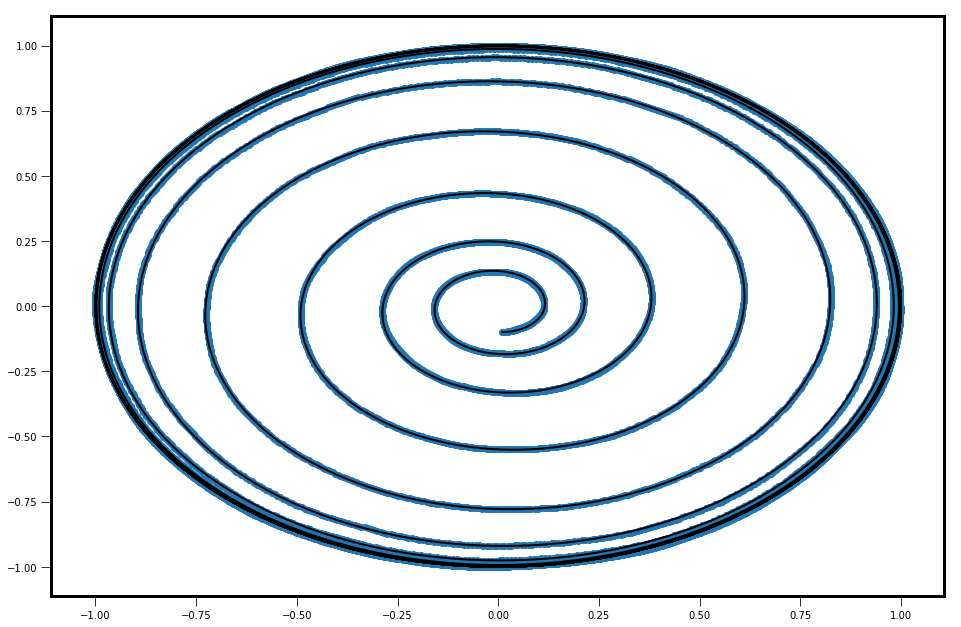

In [70]:
# plot reconstruction error on this trajectory (first two coordinates)
fig = plt.figure(figsize=(16,16/3*2))
ax = fig.add_subplot(111)


plt.plot(np.array(traj3[:,0]), np.array(traj3[:,1]), 'k', linewidth=2)
plt.scatter(np.array(traj3_xk_recon[:,0]),np.array(traj3_xk_recon[:,1]))

In [71]:
# now apply network to this trajectory again, but this time for many steps
# this time, only network initial condition of the trajectory.
traj3_long_pred = np.zeros(traj3.shape)

num_steps = traj3_long_pred.shape[0]-1
omega_ic = np.zeros((1,1))

ic = np.squeeze(traj3[0,:])
traj3_long_pred[0,:] = ic
traj3_long_pred[1:,:] = n.PredictKoopmanNetOmegas(ic, W, b, deltat, num_steps, params['num_real'], params['num_complex_pairs'], 
                                                        params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])

    

trajectory: worst rel. error 0.089


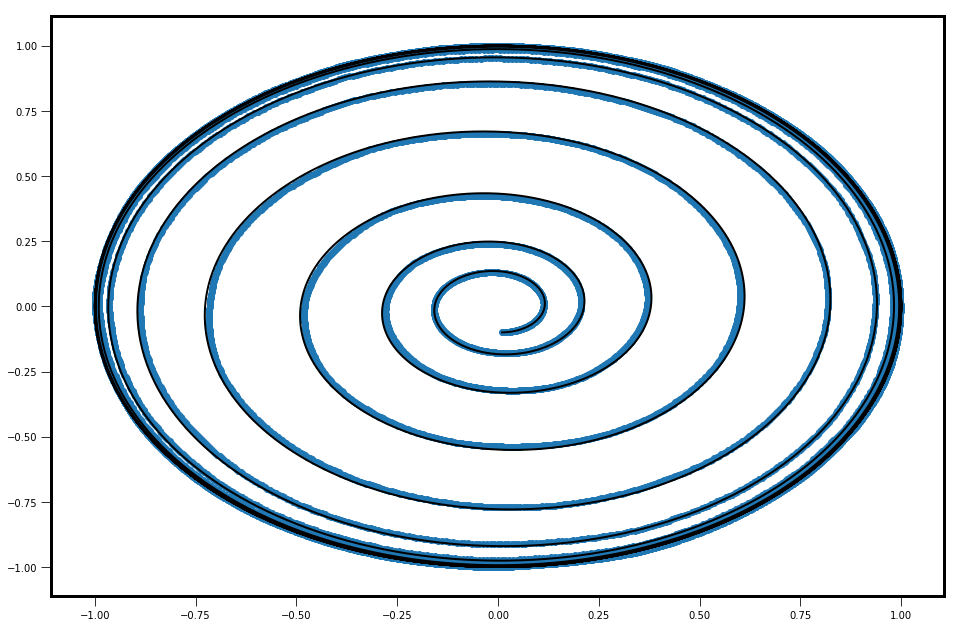

In [72]:
# plot long-term prediction:
# if only give network initial condition, then have network predict many steps, how long is it accurate?
fig = plt.figure(figsize=(16,16/3*2))
ax = fig.add_subplot(111)

plt.plot(traj3[:,0],traj3[:,1], 'k', linewidth=2)
diffs = np.linalg.norm(traj3 - traj3_long_pred,ord=2,axis=1)
normalize = np.linalg.norm(traj3,ord=2,axis=1)
relerr = diffs/normalize
print("trajectory: worst rel. error %.3f" % (np.max(relerr)))
indBigErr = np.nonzero(relerr > .1) # 10% error 
if len(indBigErr[0]) > 0:
    print("\tfirst ind with error > 10p: %d of %d"  % (indBigErr[0][0], traj3.shape[0]) )

plt.scatter(traj3_long_pred[:,0],traj3_long_pred[:,1])


In [73]:
%matplotlib notebook

<IPython.core.display.Javascript object>


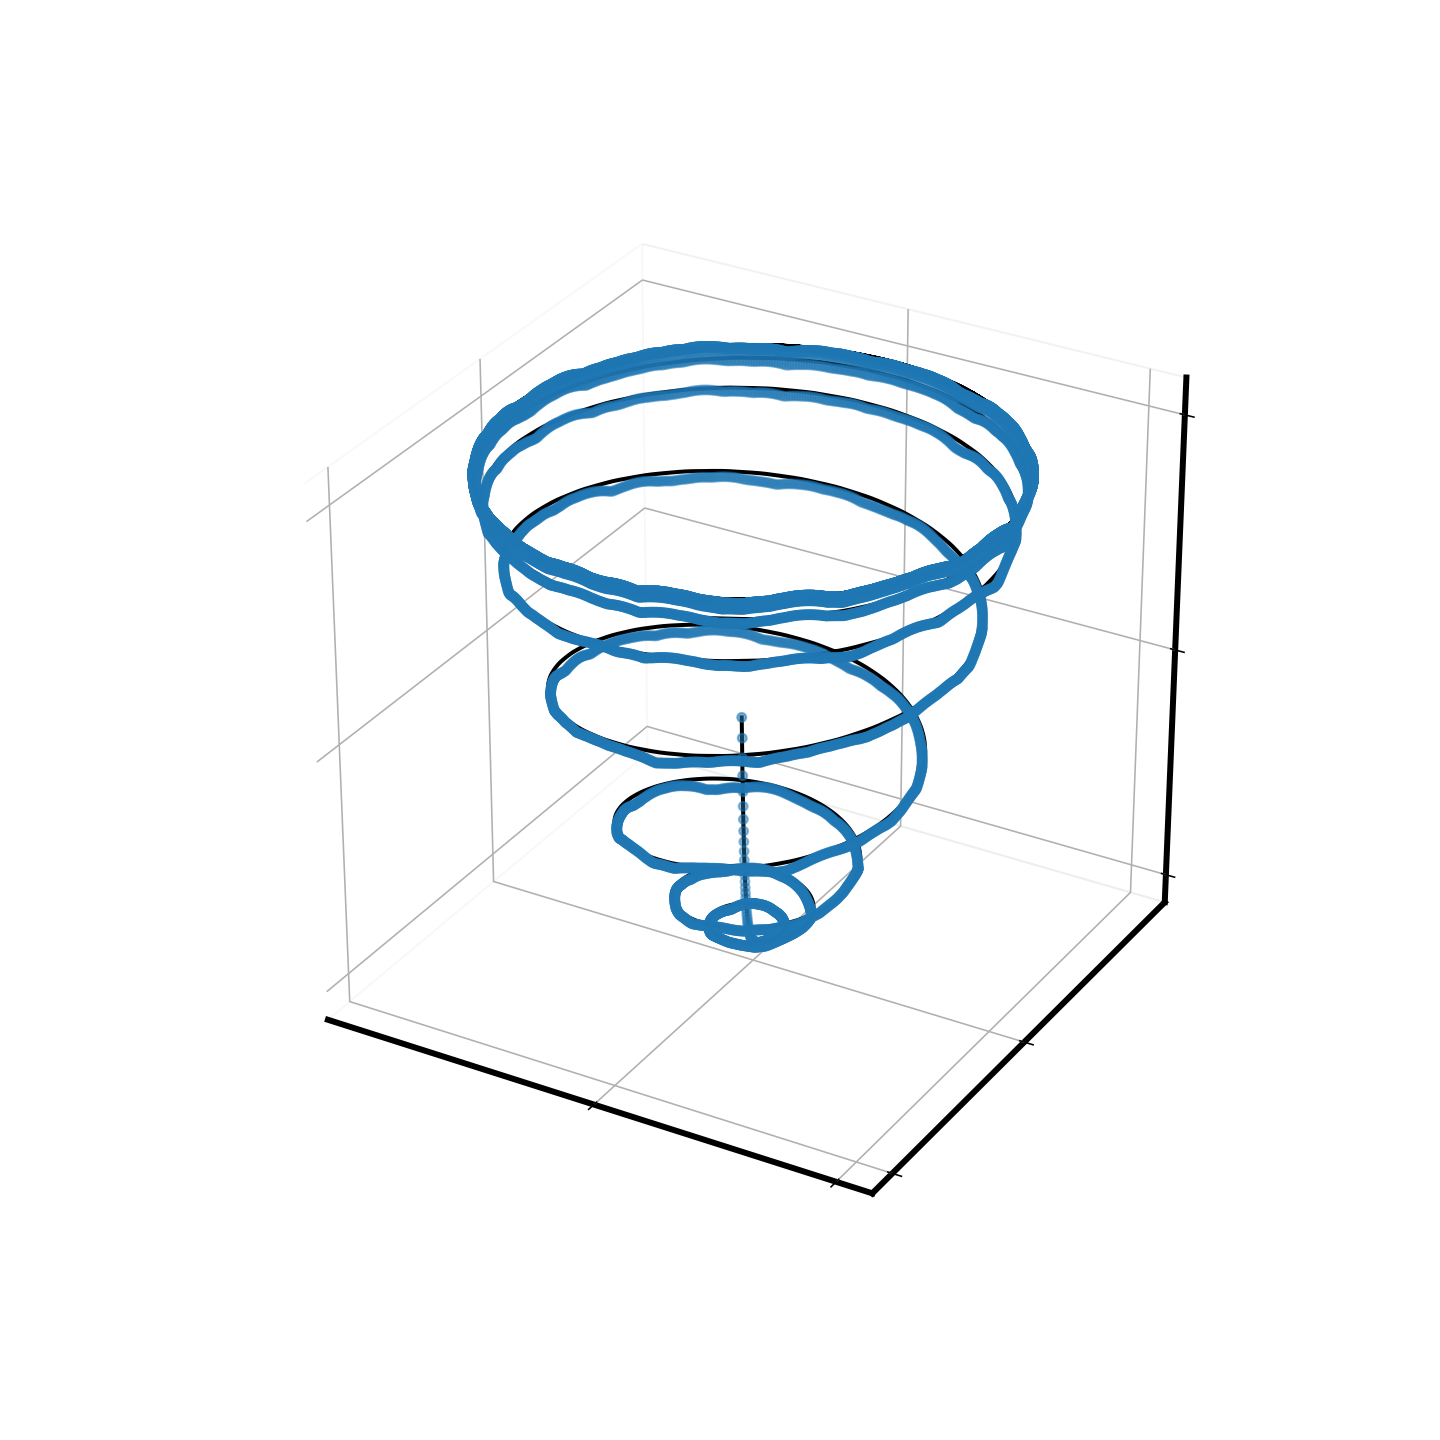

In [74]:
# Figure 6c, right
# plot long-term prediction again, but 3d this time
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax = fig.add_subplot(111, projection='3d')

ax.plot(np.array(traj3[:,0]), np.array(traj3[:,1]), np.array(traj3[:,2]), 'k', linewidth=2)
ax.scatter(np.array(traj3_long_pred[:,0]),np.array(traj3_long_pred[:,1]),np.array(traj3_long_pred[:,2]))

xlab = [0,1]
xlabels = ''
ax.set_xticks(xlab)
ax.set_xticklabels(xlabels)

ylab = [-1,0]
ylabels = ''
ax.set_yticks(ylab)
ax.set_yticklabels(ylabels)

zlab = [0,0.5,1]
zlabels = ''
ax.set_zticks(zlab)
ax.set_zticklabels(zlabels)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')


plt.show()
fig.savefig('OffBowlLongPred3.svg', dpi=200, transparent=True)


In [75]:
# send all initial conditions through network again, but predict many steps
print('We now predict the initial conditions %d steps forward' % max_shifts_to_stack)
long_pred_Xk = n.PredictKoopmanNetOmegas(Xk, W, b, deltat, max_shifts_to_stack, params['num_real'], params['num_complex_pairs'], 
                                                        params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])


We now predict the initial conditions 100 steps forward


In [76]:
# how does prediction error change with the number of prediction steps?
# we expect it to accumulate error, but hopefully not too fast
long_pred_error = np.zeros((max_shifts_to_stack, ))
for j in np.arange(max_shifts_to_stack):
    long_pred_error[j] = np.mean(np.mean(np.square(long_pred_Xk[:,j,:] - X_stacked[j+1,:,:]), axis=0)) 

In [77]:
# so we can put ticks in good places
print('log10 error ranges from %.2f to %.2f' % (min(np.log10(long_pred_error)), max(np.log10(long_pred_error))))

log10 error ranges from -5.12 to -4.46


In [78]:
%matplotlib inline

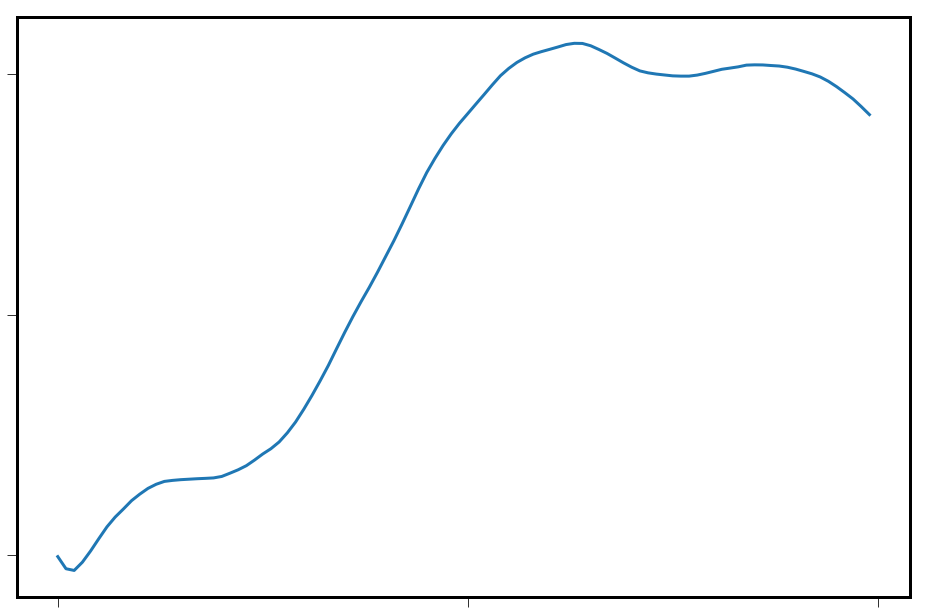

In [79]:
# Supplementary Figure 7a
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figwidth(16)
fig.set_figheight(16/3*2)

plt.plot(np.arange(max_shifts_to_stack), np.log10(long_pred_error), linewidth=3)

xlab = [0,50,100]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-5.1,-4.8,-4.5]
ylabels = ''
plt.yticks(ylab,ylabels)
fig.savefig('CylinderOffBowlPredOverSteps.svg', dpi=200, transparent=True)

In [80]:
# moved this to the bottom because it's so slow
loss1_train, loss2_train, loss3_train, loss_Linf_train, loss_train, regularized_loss_train, total_num_traj = n.loss_training(params, max_shifts_to_stack, W, b)
print("# training traj: %d (goes in Table 2)" % total_num_traj)

file 1 has 5000 trajectories
file 2 has 5000 trajectories
file 3 has 5000 trajectories
file 4 has 5000 trajectories
# training traj: 20000 (goes in Table 2)


In [81]:
print('Reconstruction loss (on train set): %.4E' % loss1_train)
print('Prediction loss (on train set): %.4E' % loss2_train)
print('Linearity loss (on train set): %.4E' % loss3_train)
print('L_inf loss (on train set): %.4E' % loss_Linf_train)
print('Pre-regularization loss (on train set): %.4E (goes in Table 1)' % loss_train)
print('Total regularized loss (on train set): %.4E' % regularized_loss_train)

Reconstruction loss (on train set): 8.5234E-07
Prediction loss (on train set): 9.3929E-07
Linearity loss (on train set): 1.0332E-06
L_inf loss (on train set): 4.0138E-11
Pre-regularization loss (on train set): 2.8249E-06 (goes in Table 1)
Total regularized loss (on train set): 2.8249E-06


# Test error

DO NOT CALCULATE UNTIL READY TO REPORT FINAL RESULTS

In [83]:
## We decided to report this example in the paper, so now we can calcuate test errror
#loss1_test, loss2_test, loss3_test, loss_Linf_test, loss_test, regularized_loss_test = n.loss_test(params, max_shifts_to_stack, W, b)

test file has 5000 trajectories


In [84]:
#print('Reconstruction loss (on test set): %.4E' % loss1_test)
#print('Prediction loss (on test set): %.4E' % loss2_test)
#print('Linearity loss (on test set): %.4E' % loss3_test)
#print('L_inf loss (on test set): %.4E' % loss_Linf_test)
#print('Pre-regularization loss (on test set): %.4E (goes in Table 1)' % loss_test)
#print('Total regularized loss (on test set): %.4E' % regularized_loss_test)

Reconstruction loss (on test set): 9.1814E-07
Prediction loss (on test set): 9.3035E-07
Linearity loss (on test set): 1.0222E-06
L_inf loss (on test set): 3.5839E-11
Pre-regularization loss (on test set): 2.8707E-06 (goes in Table 1)
Total regularized loss (on test set): 2.8707E-06
